In [1]:
import numpy as np
f = open('resources/InsectWingbeatSound/InsectWingbeatSound_TEST','r')
data = f.read()
f.close()
# 개행문자 기준으로 끊어서 리스트로
data_list = data.split('\n')

# "," 기준으로 끊어서 리스트로
emptylist = []
for list_part in data_list:
    emptylist.append(list_part.split(","))

In [2]:
# str -> float 변환
tofloat = []
for partlist in emptylist:
    tofloat.append([float(i) for i in partlist]) 

In [3]:
labels = []
data_list = []
for datas in tofloat:
    labels.append(datas[0])
    data_list.append(datas[1:])
print(np.shape(labels))
print(np.shape(data_list))


(1980,)
(1980, 256)


In [4]:
print(max(labels))
print(min(labels))

11.0
1.0


In [5]:
from readFile import split_into_values, toRPdata
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from tslearn.preprocessing import TimeSeriesScalerMeanVariance, TimeSeriesResampler

def Standard(data):
    SS = StandardScaler().fit(data)
    scaled = SS.transform(data)
    return scaled

def MinMax(data):
    MMS = MinMaxScaler().fit(data)
    scaled = MMS.transform(data)
    return scaled

# result_list transpose
result_T = [list(x) for x in zip(*data_list)]

# minmax 정규화
result_scaled = Standard(result_T)

# 다시 result transpose 해서 원래대로
result_scaled = [list(x) for x in zip(*result_scaled)]

result_ = np.array(result_scaled)

In [6]:
result_.shape

(1980, 256)

In [7]:
data = result_.reshape(result_.shape[0], 1, result_.shape[1])
X = toRPdata(data, threshold='point', percentage=30)
#X = toRPdata(data)
    
X_scaled = np.expand_dims(X, axis=3)
X_scaled.shape

(1980, 256, 256, 1)

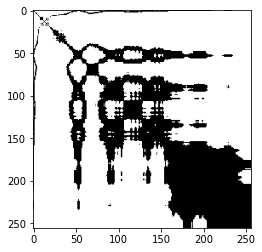

In [8]:
from matplotlib import pyplot as plt
plt.imshow(X[0], cmap='Greys')

In [9]:
learning_rate = 3e-3
optimizer='Adam'
loss='binary_crossentropy'
image_size = 256 #1024, 256
dimension = 4 # ...

In [10]:
batch_size = 10
epochs = 5000

In [ ]:
from utils import split_data, normalization_tool
from agent import Autoencoder_Agent
from keras import backend as K
import tensorflow as tf
X_train, X_test, Y_train, Y_test = split_data(X_scaled, X_scaled) #데이터 분리

mirrored_strategy = tf.distribute.MirroredStrategy(devices=["/gpu:0", "/gpu:1"], cross_device_ops=tf.distribute.HierarchicalCopyAllReduce())
with mirrored_strategy.scope():
    autoencoder = Autoencoder_Agent(model_size=image_size, dimension=dimension, optimizer=optimizer,learning_rate=learning_rate)
    hist = autoencoder.train(X_train,batch_size,epochs,X_test)
#     feature = autoencoder.feature_extract(X_scaled)
#     print(feature)
#     print(feature.shape)
# with tf.device('/cpu:0'):
#     autoencoder = Autoencoder_Agent(model_size=image_size, dimension=dimension, optimizer=optimizer,learning_rate=learning_rate)
#     hist = autoencoder.train(X_train,batch_size,epochs,X_test)
#     feature = autoencoder.feature_extract(X_scaled)

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 256, 256, 128)     1280      
_________________________________________________________________
activation (Activation)      (None, 256, 256, 128)     0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 128, 128, 128)     0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 128, 64)      73792     
_________________________________________________________________
activation_1 (Activation)    (None, 128, 128, 64)      0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 64,

Epoch 10/5000
149/149 [==============================] - ETA: 0s - loss: 0.6097
Epoch 00010: val_loss did not improve from 0.60937
149/149 [==============================] - 17s 113ms/step - loss: 0.6097 - val_loss: 0.6094
Epoch 11/5000
149/149 [==============================] - ETA: 0s - loss: 0.6097
Epoch 00011: val_loss did not improve from 0.60937
149/149 [==============================] - 17s 114ms/step - loss: 0.6097 - val_loss: 0.6096
Epoch 12/5000
149/149 [==============================] - ETA: 0s - loss: 0.6096
Epoch 00012: val_loss improved from 0.60937 to 0.60934, saving model to insectWing_dimension_4.h5
149/149 [==============================] - 17s 112ms/step - loss: 0.6096 - val_loss: 0.6093
Epoch 13/5000
149/149 [==============================] - ETA: 0s - loss: 0.6096
Epoch 00013: val_loss did not improve from 0.60934
149/149 [==============================] - 17s 115ms/step - loss: 0.6096 - val_loss: 0.6096
Epoch 14/5000
149/149 [==============================] - ETA:

In [13]:
it = int(1980 / 30) 
all_feature = np.array(autoencoder.feature_extract(X_scaled[0:30]))
for i in range(1, it):
    feature = autoencoder.feature_extract(X_scaled[i*30:(i+1)*30])
    all_feature = np.concatenate([all_feature, feature])
print(all_feature)
print(all_feature.shape)

[[0.01763297 0.         0.         ... 0.05126805 0.10514829 0.1502502 ]
 [0.0025138  0.         0.         ... 0.06736211 0.05718368 0.09721424]
 [0.0305176  0.         0.04115462 ... 0.07261652 0.07220548 0.06760643]
 ...
 [0.04467504 0.00881677 0.         ... 0.08224609 0.1502502  0.1502502 ]
 [0.         0.         0.         ... 0.13210015 0.1502502  0.1502502 ]
 [0.08075318 0.00418469 0.01429312 ... 0.0385666  0.06604405 0.05031005]]
(1980, 64)


In [ ]:


%matplotlib inline
import matplotlib.pyplot as plt

fig, loss_ax = plt.subplots()


loss_ax.plot(hist.history['loss'], 'y', label='train loss')
loss_ax.plot(hist.history['val_loss'], 'r', label='val loss')
# loss_ax.plot([hist['loss'][i] - hist['val_loss'][i] for i in range(len(hist['loss']))], 'g', label='loss - val loss')


loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')

loss_ax.legend(loc='upper left')

plt.show()

In [170]:
dic_labels = {}
for i in labels:
    if f'{i}' not in dic_labels.keys():
        dic_labels[f'{i}'] = 1
    else:
        dic_labels[f'{i}'] += 1

for key, value in dic_labels.items():
    print(f"{key}: {value}")

11: 180
3: 180
6: 180
1: 180
5: 180
4: 180
2: 180
10: 180
7: 180
9: 180
8: 180


In [171]:
labels_ = cluster_result.labels_ + 1
dic_labels_ = {}
for i in labels_:
    if f'{i}' not in dic_labels_.keys():
        dic_labels_[f'{i}'] = 1
    else:
        dic_labels_[f'{i}'] += 1

for key, value in dic_labels_.items():
    print(f"{key}: {value}")

4: 87
9: 135
8: 514
3: 122
5: 248
6: 164
1: 126
10: 104
2: 223
11: 160
7: 97


In [172]:
# 각 label 별 리스트 나누기
# labels : 기존 라벨
# all_feature : dataset

# labels == 1 인 인덱스 : idx
# cluster_1 = all_feature[idx]

for i in range(1, 12):
#     features = np.empty((1,32))
    indexes = []
    for idx, label in enumerate(labels):
        if label == i:
            indexes.append(idx)
    features = all_feature[indexes]
    result = cluster_result.predict(features)
    print(result)
#     print(features)
#     print(features.shape)

# 리스트 별로 predict 진행
# 결과 저장

[ 2  2  9  9  2  9  9  2  2  9  2  9  2  9  9  2  9 10  2  2  9  5  9  9
  9  5 10  2  5  9  5  2  2  2  2  2  9  2  9  2  2  9  3  2  0  2  9  2
  2  2  9  9  9  2  5  9  9  9  2  9  2  2  2  9  9  9  2  2  9  2 10  9
  9  1  9  2  9  2  9  9  2  9  9 10  9  2  2  9  9 10 10  9  9  9 10  2
  9  2  2  9  2  2  9  1  2  9  2  9  1  2  2  2  9 10  2  1  2  2 10 10
  2  9  2  2  2  2  5  2  9 10  9  2  2  9  2  2  2  2  9  5  9  2  2  2
  9  9  9  9  2  2  2  9 10  9  2  9  9  2  9 10  2  9  9  9  2  2  9  2
  9  2  9  9  9  9  9  9  9  2  9  1]
[ 0  4  0  4  6  4  3  4  8  6  7  0  4  8  3  4  3  6  8  7  4  7  8  0
  8  7  3  0  0  8  4  8  3  7  4  0  3  8  1  3  4  4  6  4  8  3  4  0
  6  8  8  3  6  3  4  8  5  8  8  7  8  4  7  8  3  6  4  3  6  0  6  7
  8  8  4  4  4  9  7  4  3  8  8  8  0  7  4  4  1  8  6  4  8  4  8  8
  8  4  6  3  7  0  6  4  7  6  4  8  4  0  4  4  8  4  4  3  0  7  4  6
  8  4  3  4  7  7  4  6  8  0  0  8  4  4  7  4  8  4 10  7  8  8  4  7
  6  8  0  4 

In [15]:
from sklearn.cluster import KMeans
# Cluster Algorithm
cluster_result = KMeans(n_clusters=11).fit(all_feature)

In [16]:
from sklearn.metrics import silhouette_samples,silhouette_score
def plotSilhouette(X, y_km):
    cluster_labels = np.unique(y_km.labels_)
    n_clusters = cluster_labels.shape[0]
    silhouette_vals = silhouette_score(X, y_km.labels_,metric='euclidean')
    print(silhouette_vals)
    
plotSilhouette(all_feature,cluster_result)

0.16142237


In [41]:
array4 = array1.reshape(1, 3)  # [[1,2,3]]
array5 = array2.reshape(1, 3)  # [[4,5,6]]

# 2차원 배열을 위아래로 합치기

array6 = np.concatenate([array4, array5], axis=0)
print(array6.shape)
print(array6)


(6,)
[1 2 3 4 5 6]
---------------------------
(2, 3)
[[1 2 3]
 [4 5 6]]
---------------------------
(1, 6)
[[1 2 3 4 5 6]]


ValueError: all the input array dimensions for the concatenation axis must match exactly, but along dimension 1, the array at index 0 has size 0 and the array at index 1 has size 32